In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [ ]:
!mamba install -y -c rapidsai -c conda-forge -c nvidia \
    cuml=23.12 python=3.10 cudatoolkit=11.8


Looking for: ['cuml=23.12', 'python=3.10', 'cudatoolkit=11.8']

[+] 0.0s
rapidsai/linux-64 (check zst)                      Checked  0.1s
[+] 0.0s
rapidsai/noarch (c..  ⣾  rapidsai/noarch (check zst)                       
[+] 0.0s
nvidia/linux-64 (c..  ⣾  nvidia/linux-64 (check zst)                       
[+] 0.0s
nvidia/noarch (che..  ⣾  nvidia/noarch (check zst)                         
[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  
rapidsai/linux-64     ⣾  
rapidsai/noarch       ⣾  
nvidia/linux-64       ⣾  rapidsai/linux-64                                 
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  
rapidsai/noarch       ⣾  
nvidia/linux-64       ⣾  
nvidia/noarch         ⣾  rapidsai/noarch                                   
nvidia/noarch                                     
[+] 0.2s
conda-forge/linux-64   2%
conda-forge/noarch     1%
nvidia/linux-64       23%nvidia/linux-64                                   
[+] 0.3s
conda-forge/linux-64   6%
conda

In [ ]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from cuml.svm import SVC
import cupy as cp
from cuml.svm import LinearSVC
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# Reshaping των features και των labels

X_train_reshaped = x_train.reshape(len(x_train), -1).astype(np.float32) / 255.0
X_test_reshaped  = x_test.reshape(len(x_test),  -1).astype(np.float32) / 255.0

y_train_reshaped = y_train.reshape(-1)
y_test_reshaped  = y_test.reshape(-1)

print("X_Train shape:", X_train_reshaped.shape)
print("y_Train shape:", y_train_reshaped.shape)
print("Test :", X_test_reshaped.shape)
print("Train:", y_test_reshaped.shape)

X_Train shape: (50000, 3072)
y_Train shape: (50000,)
Test : (10000, 3072)
Train: (10000,)


In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_reshaped, y_train_reshaped, test_size=0.2, random_state=42, stratify=y_train_reshaped)

print("X_train shape:", X_tr.shape)
print("y_train shape:", y_tr.shape)
print("X_validation shape:", X_val.shape)
print("y_validation shape:", y_val.shape)

X_train shape: (40000, 3072)
y_train shape: (40000,)
X_validation shape: (10000, 3072)
y_validation shape: (10000,)


In [ ]:
# Κανονικοποιηση: z=(x-μ)/σ

scaler = StandardScaler()

X_tr_sc = scaler.fit_transform(X_tr)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test_reshaped)

# **SVM**

In [ ]:
# PCA

pca = PCA(n_components=0.9)
X_tr_pca  = pca.fit_transform(X_tr_sc)
X_val_pca  = pca.transform(X_val_sc)
X_test_pca=pca.transform(X_test_sc)

In [ ]:
X_tr_gpu = cp.asarray(X_tr_pca)
y_tr_gpu = cp.asarray(y_tr)

X_val_gpu = cp.asarray(X_val_pca)
y_val_gpu = cp.asarray(y_val)

X_test_gpu = cp.asarray(X_test_pca)
y_test_gpu = cp.asarray(y_test_reshaped)

In [ ]:
svm = SVC(kernel="rbf", C=5.0, gamma="scale")
svm.fit(X_tr_gpu, y_tr_gpu)

SVC()

In [ ]:
# Train accuracy
train_pred = svm.predict(X_tr_gpu)
train_acc  = accuracy_score(cp.asnumpy(y_tr_gpu), cp.asnumpy(train_pred))

# Validation accuracy
val_pred = svm.predict(X_val_gpu)
val_acc  = accuracy_score(cp.asnumpy(y_val_gpu), cp.asnumpy(val_pred))

# Test accuracy

test_pred = svm.predict(X_test_gpu)
test_acc  = accuracy_score(cp.asnumpy(y_test_gpu), cp.asnumpy(test_pred))

print("SVM train accuracy:", train_acc)
print("SVM validation accuracy:", val_acc)
print("SVM test accuracy:", test_acc)


SVM train accuracy: 0.871775
SVM validation accuracy: 0.5565
SVM test accuracy: 0.5535


# **Confusion Matrix for SVM**

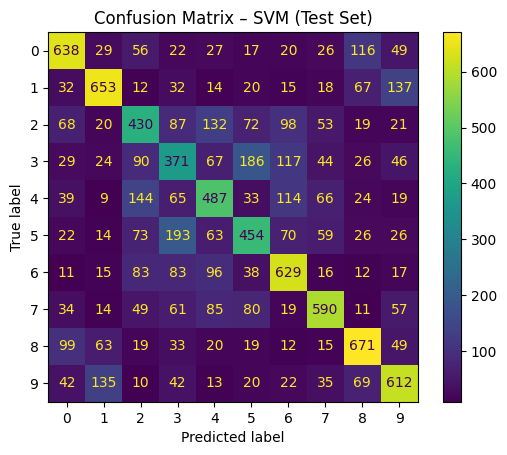

In [ ]:
cm = confusion_matrix(y_test_reshaped, cp.asnumpy(test_pred))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix – SVM (Test Set)")
plt.show()

# **MLP**

In [ ]:
# One-hot τα labels

y_tr_h = 2 * to_categorical(y_tr, 10) - 1
y_val_h = 2 * to_categorical(y_val, 10) - 1
y_test_h = 2 * to_categorical(y_test_reshaped, 10) - 1


In [ ]:
lr_scheduler = ReduceLROnPlateau(
monitor='val_loss', factor=0.5, # κοβει το lr στη μεση
patience=3, # αν για 3 epochs δεν βελτιωνεται το val_loss
min_lr=1e-6 # Ριξε το learning rate μεχρι 10^-6 = 0.000001
)

early_stopping = EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True )


mlp = Sequential([
    Input(shape=(3072,)),

    Dense(2048),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(10)
])


mlp.compile(optimizer=Adam(learning_rate=5e-4), loss='hinge', metrics=['categorical_accuracy'])

mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,322,186 (24.12 MB)

 Trainable params: 6,318,090 (24.10 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [ ]:
start = time.time()

history = mlp.fit(X_tr_sc, y_tr_h, batch_size=256, epochs=50, validation_data=(X_val_sc, y_val_h), shuffle=True, callbacks=[early_stopping, lr_scheduler])

train_time = time.time() - start
print(f"Training time: {train_time:.2f}s")

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - categorical_accuracy: 0.2985 - loss: 0.4063 - val_categorical_accuracy: 0.4366 - val_loss: 0.2745 - learning_rate: 5.0000e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.3935 - loss: 0.2775 - val_categorical_accuracy: 0.4529 - val_loss: 0.2473 - learning_rate: 5.0000e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.4271 - loss: 0.2577 - val_categorical_accuracy: 0.4801 - val_loss: 0.2282 - learning_rate: 5.0000e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - categorical_accuracy: 0.4611 - loss: 0.2400 - val_categorical_accuracy: 0.4879 - val_loss: 0.2221 - learning_rate: 5.0000e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - categorical_accuracy: 0.4702 - loss: 0.2290 - val_categorical_accuracy: 0.4931 - val_loss: 0.2164 - learning_rate: 5.0000e-04
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.4901 - loss: 0.2194 -

# **Evaluate MLP Model on Test Set**

In [ ]:
test_logits = mlp.predict(X_test_sc)
test_pred2 = test_logits.argmax(axis=1)

test_acc2 = accuracy_score(y_test_reshaped, test_pred2)
print("Test accuracy:", test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy: 0.5475


# **Learning Curves**

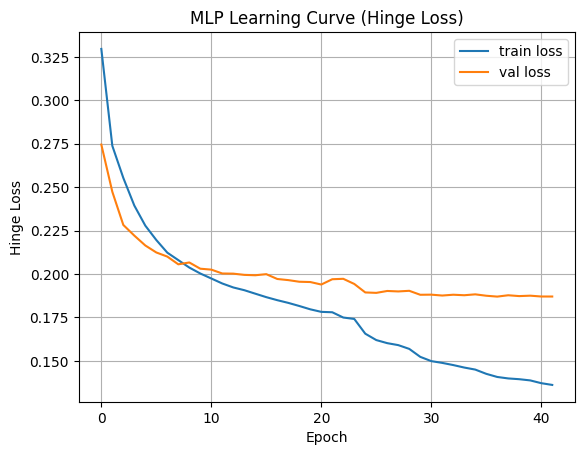

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.title("MLP Learning Curve (Hinge Loss)")
plt.legend()
plt.grid(True)
plt.show()

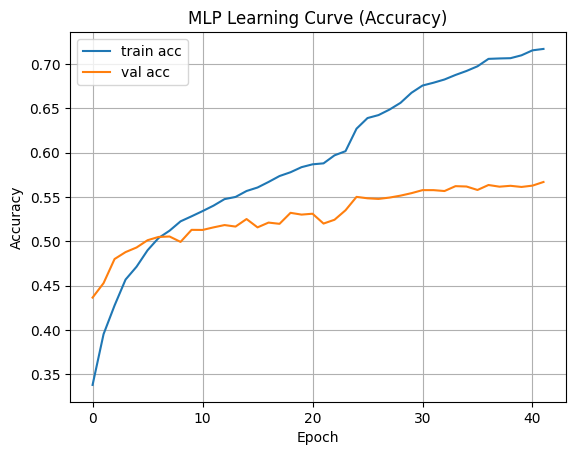

In [ ]:
plt.figure()
plt.plot(history.history["categorical_accuracy"], label="train acc")
plt.plot(history.history["val_categorical_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP Learning Curve (Accuracy)")
plt.legend()
plt.grid(True)
plt.show()

# **Confusion Matrix for MLP**

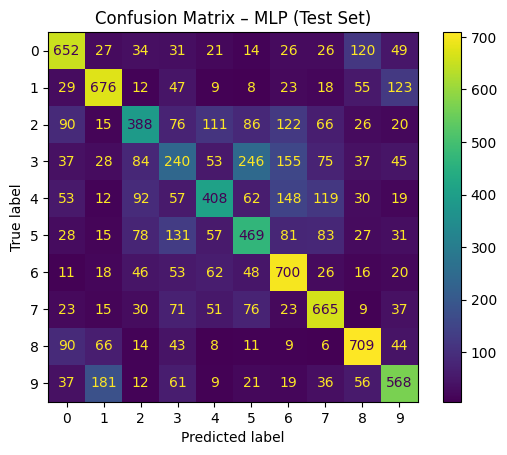

In [ ]:
cm = confusion_matrix(y_test_reshaped, test_pred2)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix – MLP (Test Set)")
plt.show()